# 1. Install and import necessary libraries

In [1]:
!pip install selenium

!pip install selenium-stealth

# install chromium-chromedriver (these commands are for ubuntu)

!apt-get update

!apt install chromium-chromedriver

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,247 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,340 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,266 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from selenium_stealth import stealth
import re
import csv
from datetime import datetime
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import sys

chrome_options = webdriver.ChromeOptions()


# google colab allows only headless mode => no gui

# disable this locally if you want to see the browser window

chrome_options.add_argument('--headless')

# set window size, click() does not work if window has no size

chrome_options.add_argument('--window-size=1920,1080')

# other options, might not be needed

chrome_options.add_argument('--no-sandbox')

chrome_options.add_argument('--disable-dev-shm-usage')

chrome_options.add_argument('--enable-javascript')


In [3]:
# takes time with am/pm and converts it to 24h format
def convert_12h_to_24h(hours_minutes):
    if 'am' in hours_minutes:
        hours_minutes = hours_minutes.split(':')
        if hours_minutes[0] == '12':
            return '00:' + hours_minutes[1].replace('am', '')
        else:
            return hours_minutes[0] + ':' + hours_minutes[1].replace('am', '')
    else:
        hours_minutes = hours_minutes.split(':')
        if hours_minutes[0] == '12':
            return hours_minutes[0] + ':' + hours_minutes[1].replace('pm', '')
        else:
            return str(int(hours_minutes[0]) + 12) + ':' + hours_minutes[1].replace('pm', '')

In [4]:
# takes time in hours:minutes and converts it to hours
def convert_to_hours(hours_minutes):
    hours = hours_minutes.split()[0]
    hours = int(hours.replace('h', ''))
    minutes = hours_minutes.split()[1]
    minutes = int(minutes.replace('m', ''))

    total_hours = round(((hours*60) + minutes) / 60, 1)
    return  total_hours

# 2 - Scrape first website (Momondo)

In [5]:
driver = webdriver.Chrome(options=chrome_options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
driver.maximize_window()

driver.get('https://www.momondo.com/flight-search/HEL-AGP/2023-12-20')
time.sleep(5)

# Click load more button to load all flights
print('Loading pages, please wait...')
while True:
    try:
        show_more_btn = driver.find_element(By.XPATH, '//div[@class="ULvh-button show-more-button"]')
        show_more_btn.click()
        time.sleep(4)
    except:
        break

# Expand all flights to get all data
print('Loading flights, please wait...')
flight_clicks = driver.find_elements(By.XPATH, '//div[@class="nrc6-inner"]')
for flight_click in flight_clicks:
    try:
        flight_click.click()
        time.sleep(1)
    except:
        continue

soup = BeautifulSoup(driver.page_source, 'lxml')
flights = soup.find_all('div', class_='nrc6')

print('Found ' + str(len(flights)) + ' flights from Momondo.')

flight_list = []
print('Getting data, please wait...')
count = 0
for flight in flights:
  try:
    price = flight.find('div', class_='f8F1-price-text').text
    price = price.replace('$', '')
    price = price.replace(',', '')

    no_of_stops = flight.find('span', class_='JWEO-stops-text').text

    if (no_of_stops == 'nonstop'):
          no_of_stops = 0
          layover_time = 0
    else:
        no_of_stops = no_of_stops.split()[0]

        layover_times = flight.find_all('span', class_='c62AT-duration')
        total_layover = 0.0
        for layover_time in layover_times:
            total_layover = total_layover + convert_to_hours(layover_time.text)

        layover_time = round(total_layover, 1)


    airline = flight.find('div', class_='c_cgF-mod-variant-default').text.strip()
    airline = airline.lower()

    duration = flight.find('div', class_='xdW8')
    duration = duration.find('div').text
    duration = convert_to_hours(duration)

    flight_times = flight.find('div', class_='vmXl-mod-variant-large')
    flight_times = flight_times.find_all('span')

    departure_time = flight_times[0].text.strip()
    departure_time = convert_12h_to_24h(departure_time).strip()

    arrival_time = flight_times[-1].text
    arrival_time = arrival_time.split('+', 1)[0].strip()
    arrival_time = convert_12h_to_24h(arrival_time).strip()

    time_object = datetime.strptime(departure_time, '%H:%M').time()
    time_object = datetime.strptime(arrival_time, '%H:%M').time()

    flight_object = {
          "price": int(price),
          "airline": airline,
          "no_of_layovers": no_of_stops,
          "layover_duration": layover_time,
          "duration": duration,
          "departure_time": departure_time,
          "arrival_time": arrival_time,
          "website": 'momondo'
      }

    flight_list.append(flight_object)
    count = count + 1
  except:
    continue

print('Collected data from ' + str(count) + ' flights from Momondo.')
driver.quit()

Loading pages, please wait...
Loading flights, please wait...
Found 152 flights from Momondo.
Getting data, please wait...
Collected data from 152 flights from Momondo.


In [6]:
df = pd.DataFrame(flight_list)
df.to_csv('flights.csv', mode='w', index=False, header=True)

In [7]:
df.head()

,price,airline,no_of_layovers,layover_duration,duration,departure_time,arrival_time,website
0,236,norwegian,0,0.0,4.8,9:30,13:15,momondo
1,126,multiple airlines,2,9.1,15.5,19:45,10:15,momondo
2,281,finnair,0,0.0,4.8,6:30,10:15,momondo
3,334,finnair,0,0.0,4.8,12:10,15:55,momondo
4,235,norwegian,1,2.4,7.8,16:40,23:25,momondo


# 3 - Scrape second website (Kayak)

In [8]:
driver = webdriver.Chrome(options=chrome_options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
driver.maximize_window()

driver.get('https://www.kayak.com/flights/HEL-AGP/2023-12-20?sort=bestflight_a')
time.sleep(5)

# Click load more button to load all flights
print('Loading pages, please wait...')
while True:
    try:
        show_more_btn = driver.find_element(By.XPATH, '//div[@class="ULvh-button show-more-button"]')
        show_more_btn.click()
        time.sleep(4)
    except:
        break

# Expand all flights to get all data
print('Loading flights, please wait...')
flight_clicks = driver.find_elements(By.XPATH, '//div[@class="nrc6-inner"]')
for flight_click in flight_clicks:
    try:
        flight_click.click()
        time.sleep(1)
    except:
        continue

soup = BeautifulSoup(driver.page_source, 'lxml')
flights = soup.find_all('div', class_='nrc6')

print('Found ' + str(len(flights)) + ' flights from Kayak.')

flight_list = []
print('Getting data, please wait...')
count = 0
for flight in flights:
  try:
    price = flight.find('div', class_='f8F1-price-text').text
    price = price.replace('$', '')
    price = price.replace(',', '')

    no_of_stops = flight.find('span', class_='JWEO-stops-text').text

    if (no_of_stops == 'nonstop'):
          no_of_stops = 0
          layover_time = 0
    else:
        no_of_stops = no_of_stops.split()[0]

        layover_times = flight.find_all('span', class_='c62AT-duration')
        total_layover = 0.0
        for layover_time in layover_times:
            total_layover = total_layover + convert_to_hours(layover_time.text)

        layover_time = round(total_layover, 1)


    airline = flight.find('div', class_='c_cgF-mod-variant-default').text.strip()
    airline = airline.lower()

    duration = flight.find('div', class_='xdW8')
    duration = duration.find('div').text
    duration = convert_to_hours(duration)

    flight_times = flight.find('div', class_='vmXl-mod-variant-large')
    flight_times = flight_times.find_all('span')

    departure_time = flight_times[0].text.strip()
    departure_time = convert_12h_to_24h(departure_time).strip()

    arrival_time = flight_times[-1].text
    arrival_time = arrival_time.split('+', 1)[0].strip()
    arrival_time = convert_12h_to_24h(arrival_time).strip()

    time_object = datetime.strptime(departure_time, '%H:%M').time()
    time_object = datetime.strptime(arrival_time, '%H:%M').time()

    flight_object = {
          "price": int(price),
          "airline": airline,
          "no_of_layovers": no_of_stops,
          "layover_duration": layover_time,
          "duration": duration,
          "departure_time": departure_time,
          "arrival_time": arrival_time,
          "website": 'kayak'
      }

    flight_list.append(flight_object)
    count = count + 1
  except:
    continue

print('Collected data from ' + str(count) + ' flights from Kayak.')
driver.quit()

Loading pages, please wait...
Loading flights, please wait...
Found 153 flights from Kayak.
Getting data, please wait...
Collected data from 153 flights from Kayak.


In [9]:
df = pd.DataFrame(flight_list)
df.to_csv('flights.csv', mode='a', index=False, header=False)

In [10]:
df.head()

,price,airline,no_of_layovers,layover_duration,duration,departure_time,arrival_time,website
0,216,airbaltic,1,6.4,12.0,5:20,16:20,kayak
1,251,finnair,0,0.0,4.8,6:30,10:15,kayak
2,126,multiple airlines,2,9.1,15.5,19:45,10:15,kayak
3,229,norwegian,0,0.0,4.8,9:30,13:15,kayak
4,344,finnair,0,0.0,4.8,12:10,15:55,kayak


# 4 - Scrape third website (Agoda)

In [11]:
driver = webdriver.Chrome(options=chrome_options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
driver.maximize_window()

driver.get('https://flights.agoda.com/flights/HEL-AGP/2023-12-20?sort=bestflight_a')
time.sleep(5)

# Click load more button to load all flights
print('Loading pages, please wait...')
while True:
    try:
        show_more_btn = driver.find_element(By.XPATH, '//a[@class="moreButton"]')
        show_more_btn.click()
        time.sleep(4)
    except:
        break

# Expand all flights to get all data
print('Loading flights, please wait...')
flight_clicks = driver.find_elements(By.XPATH, '//div[@class="resultInner"]')
for flight_click in flight_clicks:
    try:
        flight_click.click()
        time.sleep(1)
    except:
        continue

soup = BeautifulSoup(driver.page_source, 'lxml')
flights = soup.find_all('div', class_='resultWrapper')

print('Found ' + str(len(flights)) + ' flights from Agoda.')

flight_list = []
print('Getting data, please wait...')
count = 0
for flight in flights:
  try:
    price = flight.find('span', class_='price-text').text
    price = price.replace('$', '')
    price = price.replace(',', '')

    no_of_stops = flight.find('div', class_='stops')
    no_of_stops = no_of_stops.find('div', class_='stops').text.strip()

    if (no_of_stops == 'nonstop'):
          no_of_stops = 0
          layover_time = 0
    else:
        no_of_stops = len(no_of_stops.split(','))

        layover_times = flight.find_all('span', class_='c62AT-duration')
        total_layover = 0.0
        for layover_time in layover_times:
            total_layover = total_layover + convert_to_hours(layover_time.text)

        layover_time = round(total_layover, 1)


    airline = flight.find('div', class_='carrier').text.strip()
    airline = airline.lower()

    duration = flight.find('div', class_='duration').text
    duration = convert_to_hours(duration)

    departure_time = flight.find('div', class_='depart')
    departure_time = departure_time.find('div').text.strip()
    departure_time = convert_12h_to_24h(departure_time).strip()

    arrival_time = flight.find('div', class_='return')
    arrival_time = arrival_time.find('div').text
    arrival_time = arrival_time.split('+', 1)[0].strip()
    arrival_time = convert_12h_to_24h(arrival_time).strip()

    time_object = datetime.strptime(departure_time, '%H:%M').time()
    time_object = datetime.strptime(arrival_time, '%H:%M').time()

    flight_object = {
          "price": int(price),
          "airline": airline,
          "no_of_layovers": no_of_stops,
          "layover_duration": layover_time,
          "duration": duration,
          "departure_time": departure_time,
          "arrival_time": arrival_time,
          "website": 'agoda'
      }

    flight_list.append(flight_object)
    count = count + 1
  except:
    continue

print('Collected data from ' + str(count) + ' flights from Agoda.')
driver.quit()

Loading pages, please wait...
Loading flights, please wait...
Found 145 flights from Agoda.
Getting data, please wait...
Collected data from 145 flights from Agoda.


In [12]:
df = pd.DataFrame(flight_list)
df.to_csv('flights.csv', mode='a', index=False, header=False)

In [13]:
df.head()

,price,airline,no_of_layovers,layover_duration,duration,departure_time,arrival_time,website
0,229,norwegian,0,0.0,4.8,9:30,13:15,agoda
1,126,multiple airlines,2,9.1,15.5,19:45,10:15,agoda
2,251,finnair,0,0.0,4.8,6:30,10:15,agoda
3,344,finnair,0,0.0,4.8,12:10,15:55,agoda
4,235,norwegian,1,2.4,7.8,16:40,23:25,agoda


# 5 - Perform EDA

In [14]:
data = pd.read_csv("flights.csv")

data.info()
data.drop_duplicates(inplace=True)
data.dropna()
data.info()

print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             450 non-null    int64  
 1   airline           450 non-null    object 
 2   no_of_layovers    450 non-null    int64  
 3   layover_duration  450 non-null    float64
 4   duration          450 non-null    float64
 5   departure_time    450 non-null    object 
 6   arrival_time      450 non-null    object 
 7   website           450 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 28.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 449
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             424 non-null    int64  
 1   airline           424 non-null    object 
 2   no_of_layovers    424 non-null    int64  
 3   layover_duration  4

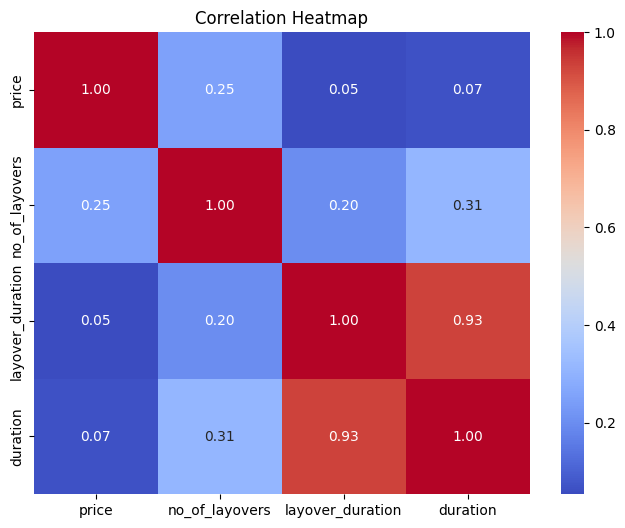

In [15]:
# Correlation heatmap for numerical columns
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

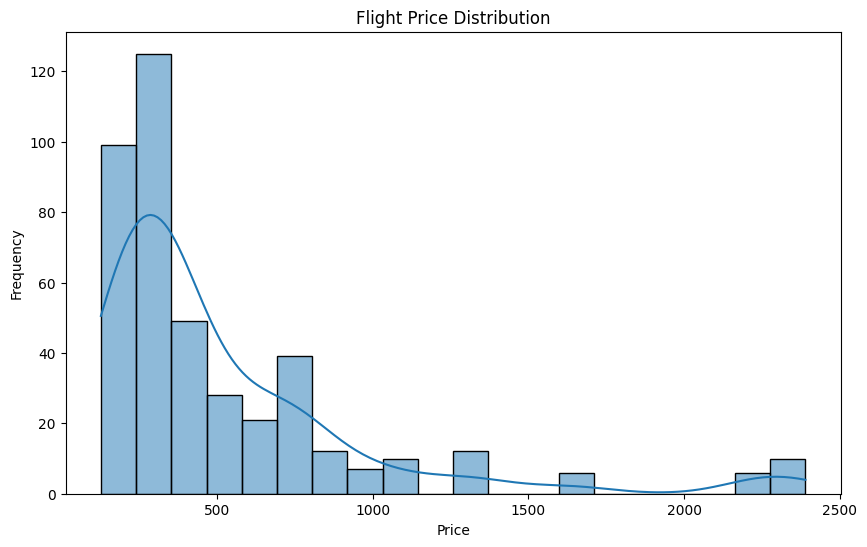

In [16]:
# Price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=20, kde=True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Flight Price Distribution')
plt.show()

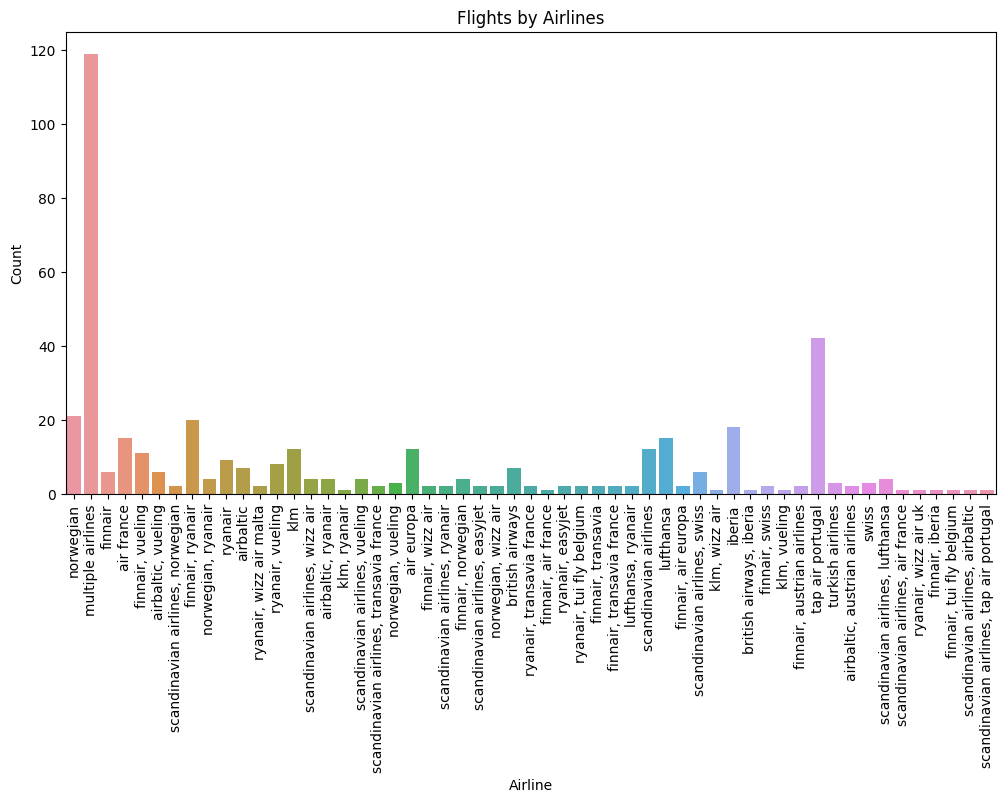

In [17]:
# Airlines distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Flights by Airlines')
plt.xticks(rotation=90)
plt.show()

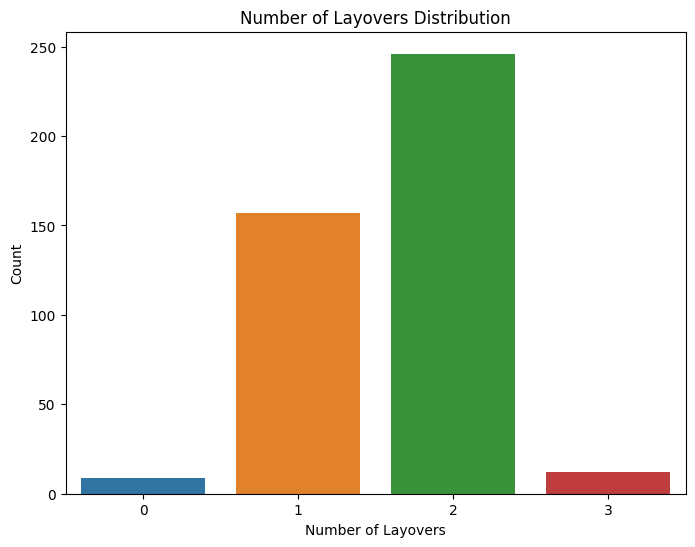

In [18]:
# Number of Layovers distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='no_of_layovers')
plt.xlabel('Number of Layovers')
plt.ylabel('Count')
plt.title('Number of Layovers Distribution')
plt.show()

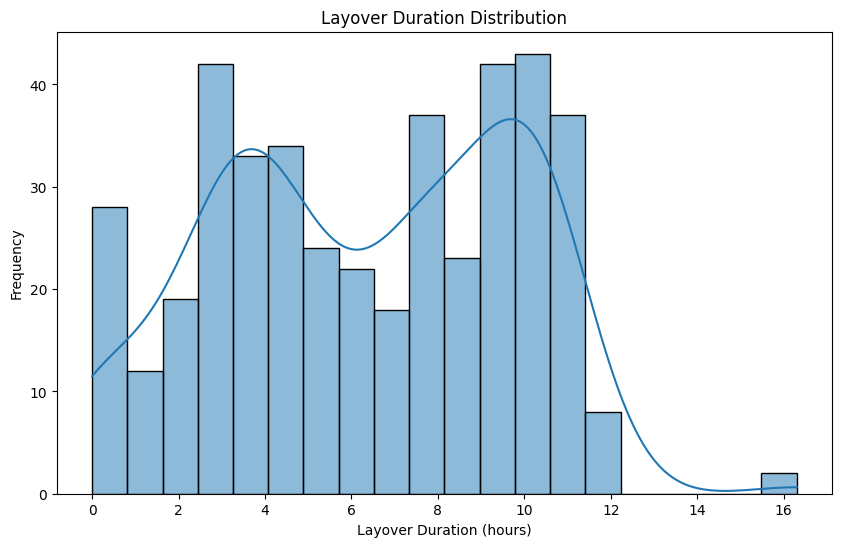

In [19]:
# Layover Duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['layover_duration'], bins=20, kde=True)
plt.xlabel('Layover Duration (hours)')
plt.ylabel('Frequency')
plt.title('Layover Duration Distribution')
plt.show()

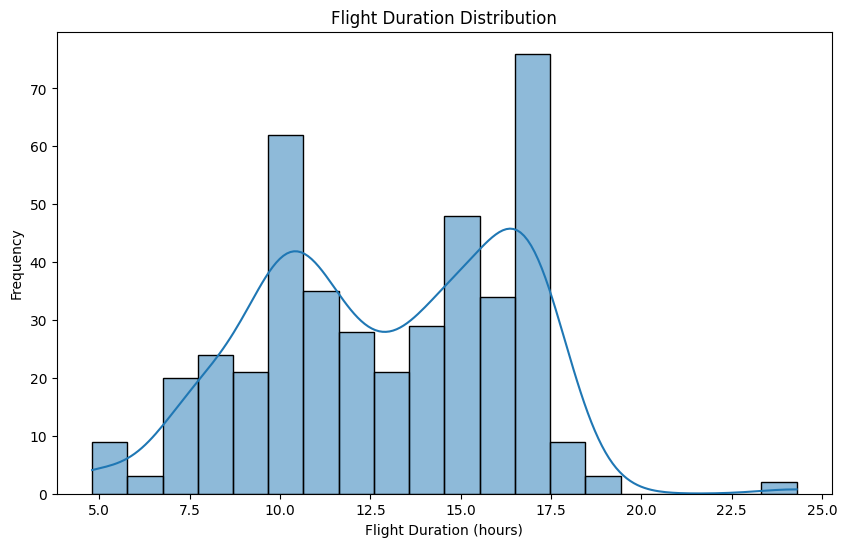

In [20]:
# Flight Duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['duration'], bins=20, kde=True)
plt.xlabel('Flight Duration (hours)')
plt.ylabel('Frequency')
plt.title('Flight Duration Distribution')
plt.show()

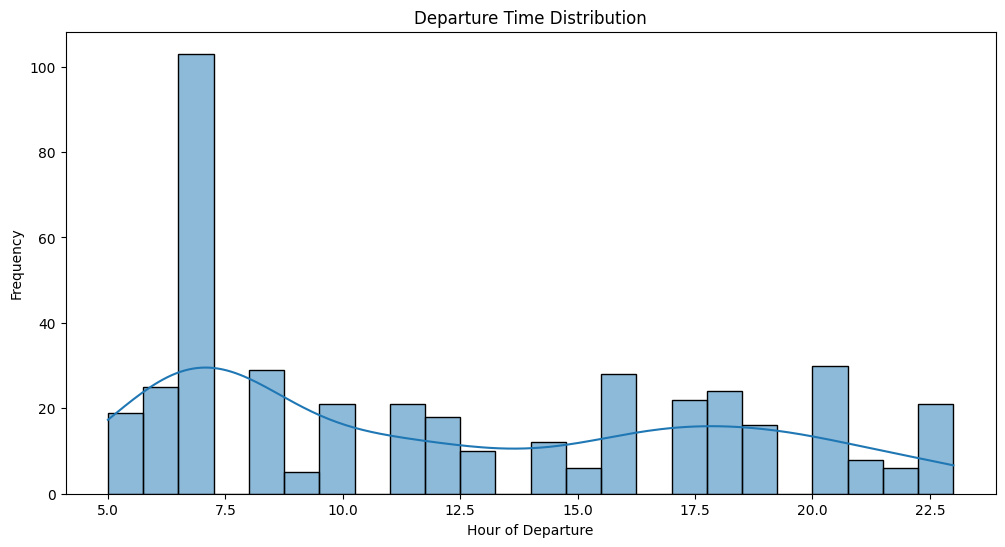

In [21]:
# Convert departure and arrival times to datetime objects
data['departure_time'] = pd.to_datetime(data['departure_time'], format='%H:%M')
data['arrival_time'] = pd.to_datetime(data['arrival_time'], format='%H:%M')

# Visualize departure times
plt.figure(figsize=(12, 6))
sns.histplot(data['departure_time'].dt.hour, bins=24, kde=True)
plt.xlabel('Hour of Departure')
plt.ylabel('Frequency')
plt.title('Departure Time Distribution')
plt.show()

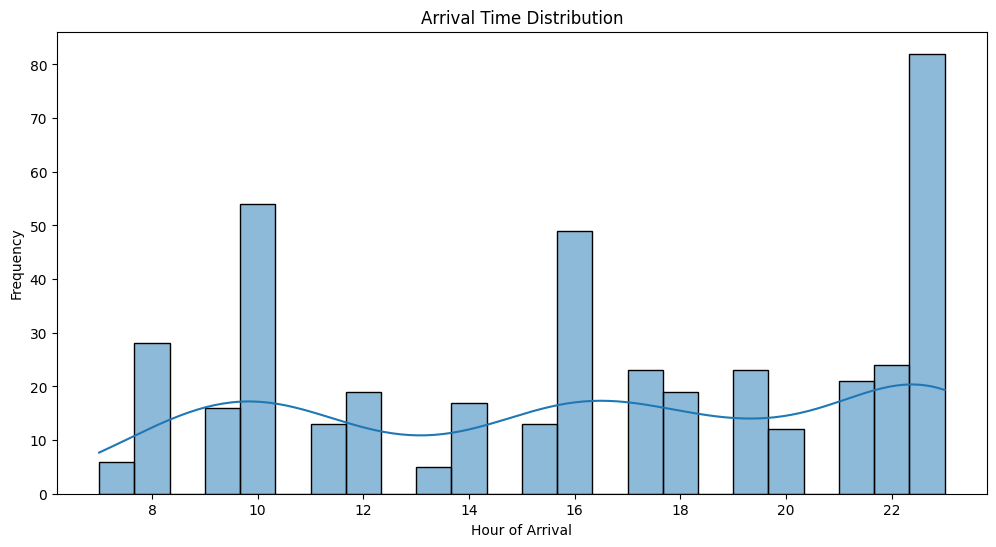

In [22]:
# Visualize arrival times
plt.figure(figsize=(12, 6))
sns.histplot(data['arrival_time'].dt.hour, bins=24, kde=True)
plt.xlabel('Hour of Arrival')
plt.ylabel('Frequency')
plt.title('Arrival Time Distribution')
plt.show()

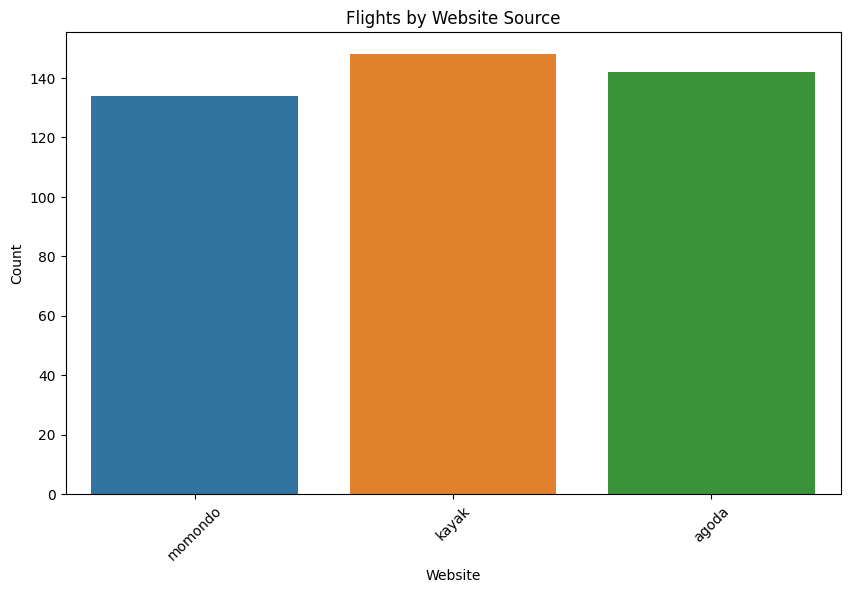

In [23]:
# Website distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='website')
plt.xlabel('Website')
plt.ylabel('Count')
plt.title('Flights by Website Source')
plt.xticks(rotation=45)
plt.show()


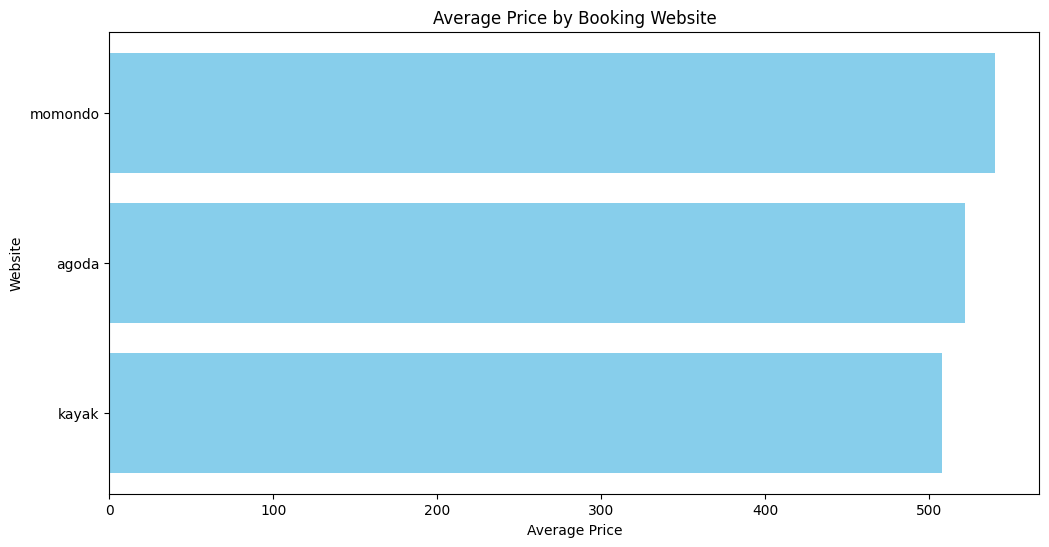

In [24]:
website_avg_prices = data.groupby('website')['price'].mean().reset_index()

# Sort the websites by average price in ascending order
website_avg_prices_sorted = website_avg_prices.sort_values(by='price')

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(website_avg_prices_sorted['website'], website_avg_prices_sorted['price'], color='skyblue')
plt.xlabel('Average Price')
plt.ylabel('Website')
plt.title('Average Price by Booking Website')
plt.show()

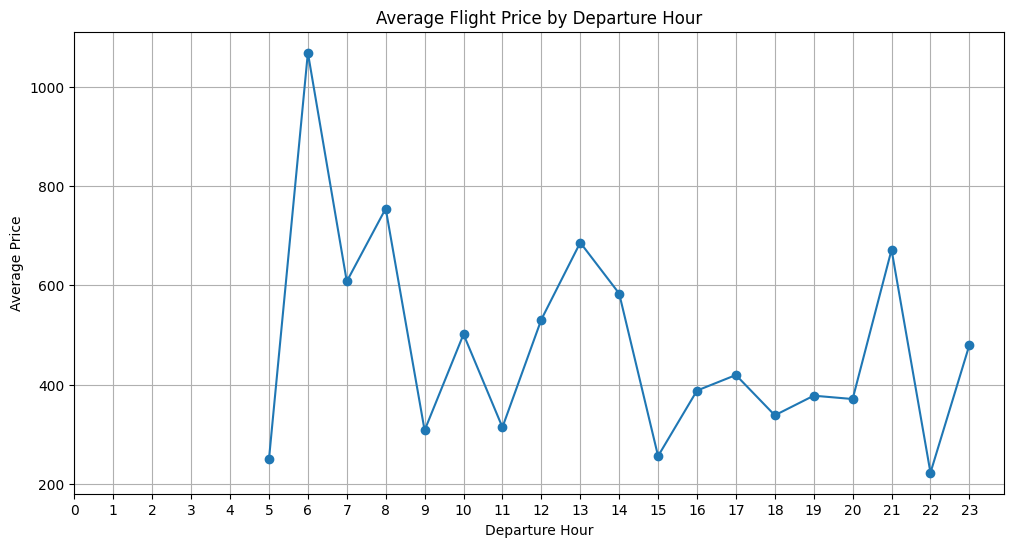

In [25]:
data['departure_hour'] = pd.to_datetime(data['departure_time'], format='%H:%M').dt.hour

# Group the data by departure hour and calculate the average price for each hour
departure_hour_avg_price = data.groupby('departure_hour')['price'].mean()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(departure_hour_avg_price.index, departure_hour_avg_price.values, marker='o', linestyle='-')
plt.xlabel('Departure Hour')
plt.ylabel('Average Price')
plt.title('Average Flight Price by Departure Hour')
plt.grid(True)  # Add grid lines for reference
plt.xticks(range(24))  # Set x-axis ticks to hours of the day (0-23)
plt.show()

# 6 - User Interaction

In [26]:
df = pd.read_csv("flights.csv")

In [29]:

def filter_flights(df, price_range, duration_range, direct_flight, airline_preference):
    # Filter based on price range
    filtered_df = df[(df['price'] >= price_range[0]) & (df['price'] <= price_range[1])]

    # Filter based on duration range
    filtered_df = filtered_df[(filtered_df['duration'] >= duration_range[0]) & (filtered_df['duration'] <= duration_range[1])]

    # Filter based on layover preference
    if direct_flight:
        filtered_df = filtered_df[filtered_df['no_of_layovers'] == 0]

    # Filter based on airline preference
    if airline_preference:
        filtered_df = filtered_df[filtered_df['airline'].str.lower() == airline_preference.lower()]

    return filtered_df

def get_cheapest_flight(filtered_df):
    cheapest_flight = filtered_df.nsmallest(1, 'price')
    return cheapest_flight

def get_fastest_flight(filtered_df):
    fastest_flight = filtered_df.nsmallest(1, 'duration')
    return fastest_flight

# Interaction with the user
print("Welcome!")

# User input for preferences
price_range = [int(input("Enter minimum price (USD): ")), int(input("Enter maximum price (USD): "))]
duration_range = [float(input("Enter minimum duration (hours): ")), float(input("Enter maximum duration (hours): "))]
direct_flight = input("Direct flight only? (yes/no): ").lower() == "yes"
airline_preference = input("Preferred airline (optional): ")

# Filter flights based on user preferences
filtered_flights = filter_flights(df, price_range, duration_range, direct_flight, airline_preference)

if filtered_flights.empty:
    print("No flights match your criteria.")
else:
    # Ask user for sorting criteria
    sort_criteria = input("Sort by (price/duration): ").lower()

    if sort_criteria == "price":
        sorted_flights = filtered_flights.sort_values(by='price')
    elif sort_criteria == "duration":
        sorted_flights = filtered_flights.sort_values(by='duration')
    else:
        print("Invalid sorting criteria. Sorting by price by default.")
        sorted_flights = filtered_flights.sort_values(by='price')

    print("Sorted Flights:")
    print(sorted_flights)

    # Get and display details of the cheapest flight
    cheapest_flight = get_cheapest_flight(sorted_flights)
    print("\nCheapest Flight:")
    print(cheapest_flight[['price', 'duration', 'no_of_layovers', 'layover_duration', 'airline']])

    # Get and display details of the fastest flight
    fastest_flight = get_fastest_flight(sorted_flights)
    print("\nFastest Flight:")
    print(fastest_flight[['price', 'duration', 'no_of_layovers', 'layover_duration', 'airline']])


Welcome!
Enter minimum price (USD): 100
Enter maximum price (USD): 500
Enter minimum duration (hours): 2
Enter maximum duration (hours): 8
Direct flight only? (yes/no): yes
Preferred airline (optional): 
Sort by (price/duration): duration
Sorted Flights:
     price    airline  no_of_layovers  layover_duration  duration  \
0      236  norwegian               0               0.0       4.8   
2      281    finnair               0               0.0       4.8   
3      334    finnair               0               0.0       4.8   
153    251    finnair               0               0.0       4.8   
155    229  norwegian               0               0.0       4.8   
156    344    finnair               0               0.0       4.8   
305    229  norwegian               0               0.0       4.8   
307    251    finnair               0               0.0       4.8   
308    344    finnair               0               0.0       4.8   

    departure_time arrival_time  website  
0          